# Importing required libraries

In [1]:
import typing

import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Data


## Load the dataset

Dataset is downloaded from [Zenodo](https://zenodo.org/records/7816008). 
We use the `PEMS08.npz` file for PEMSD8, part of the PeMS (Performance Measurement System) datasets—collected by the California Department of Transportation (Caltrans)

PeMSD8 is collected from 170 sensors in the San Bernardino County for July to August 2016

In [ ]:
pems_data = np.load("PEMS08.npz")   
pems_data = pems_data['data']
print(f"Shape of the data: {pems_data.shape}")


Shape of the data: (17856, 170, 3)


array([[[1.330e+02, 6.030e-02, 6.580e+01],
        [2.100e+02, 5.890e-02, 6.960e+01],
        [1.240e+02, 3.580e-02, 6.580e+01],
        ...,
        [7.400e+01, 2.131e-01, 6.530e+01],
        [9.400e+01, 2.260e-02, 6.800e+01],
        [6.000e+00, 3.100e-03, 6.500e+01]],

       [[1.140e+02, 5.320e-02, 6.690e+01],
        [1.850e+02, 5.500e-02, 6.850e+01],
        [1.190e+02, 3.390e-02, 6.500e+01],
        ...,
        [7.300e+01, 1.469e-01, 3.720e+01],
        [8.400e+01, 1.890e-02, 6.870e+01],
        [4.000e+00, 1.800e-03, 6.500e+01]],

       [[1.400e+02, 6.220e-02, 6.680e+01],
        [1.710e+02, 4.660e-02, 6.990e+01],
        [1.070e+02, 3.360e-02, 6.380e+01],
        ...,
        [7.000e+01, 5.860e-02, 3.400e+01],
        [8.200e+01, 2.200e-02, 6.700e+01],
        [4.000e+00, 2.100e-03, 6.490e+01]],

       ...,

       [[1.200e+02, 5.810e-02, 6.330e+01],
        [1.760e+02, 5.290e-02, 6.680e+01],
        [1.190e+02, 5.180e-02, 5.610e+01],
        ...,
        [4.700e+01, 1.551e

Feature | 	Description	Units 
- Speed:  Average speed of vehicles detected	mph or km/h
- Occupancy:  Proportion of time the detector is occupied by vehicles	percentage (0–100%)
- Flow:   Number of vehicles passing the detector during the interval	vehicles per 5 min

In [23]:
flow, occupancy, speed = pems_data[:,:,0], pems_data[:,:,1], pems_data[:,:,2]

In [ ]:
sensor_df_all = [] # store all dfs of each sensor separately
for i in range(pems_data.shape[1]):
    df = pd.DataFrame({
        "time_step": np.arange(pems_data.shape[0]),
        "sid": i,
        "speed": speed[:,i],
        "occupancy": occupancy[:,i],
        "flow": flow[:, i]
    })
    sensor_df_all.append(df)


[       time_step  sid  speed  occupancy   flow
 0              0    0   65.8     0.0603  133.0
 1              1    0   66.9     0.0532  114.0
 2              2    0   66.8     0.0622  140.0
 3              3    0   68.9     0.0452  106.0
 4              4    0   67.4     0.0574  117.0
 ...          ...  ...    ...        ...    ...
 17851      17851    0   63.9     0.0610  131.0
 17852      17852    0   62.7     0.0658  134.0
 17853      17853    0   63.3     0.0581  120.0
 17854      17854    0   61.4     0.0579  102.0
 17855      17855    0   61.7     0.0565  102.0
 
 [17856 rows x 5 columns],
        time_step  sid  speed  occupancy   flow
 0              0    1   69.6     0.0589  210.0
 1              1    1   68.5     0.0550  185.0
 2              2    1   69.9     0.0466  171.0
 3              3    1   68.0     0.0529  174.0
 4              4    1   68.7     0.0484  176.0
 ...          ...  ...    ...        ...    ...
 17851      17851    1   66.5     0.0566  191.0
 17852     

In [ ]:
data = pd.concat(sensor_df_all, ignore_index=True, axis=0)


,time_step,sid,speed,occupancy,flow
0,0,0,65.8,0.0603,133.0
1,1,0,66.9,0.0532,114.0
2,2,0,66.8,0.0622,140.0
3,3,0,68.9,0.0452,106.0
4,4,0,67.4,0.0574,117.0
5,5,0,65.5,0.0545,110.0
6,6,0,66.4,0.0566,130.0
7,7,0,63.0,0.0606,112.0
8,8,0,67.3,0.0479,115.0
9,9,0,65.7,0.0477,93.0


## Dataframe Manipulation

We want to group data by hour and day of the week to capture each sensor's history of weekly and hourly variation in features.

In [ ]:
data["dt_mins"] = pd.to_timedelta(data['time_step']*5, unit = "m")
data['day'] = (data['dt_mins'].dt.days).astype(int)
data["hour"] = (data["dt_mins"].dt.components.hours).astype(int)


,time_step,sid,speed,occupancy,flow,dt_mins,day,hour
0,0,0,65.8,0.0603,133.0,0 days 00:00:00,0,0
1,1,0,66.9,0.0532,114.0,0 days 00:05:00,0,0
2,2,0,66.8,0.0622,140.0,0 days 00:10:00,0,0
3,3,0,68.9,0.0452,106.0,0 days 00:15:00,0,0
4,4,0,67.4,0.0574,117.0,0 days 00:20:00,0,0
...,...,...,...,...,...,...,...,...
3035515,17851,169,65.2,0.0004,1.0,61 days 23:35:00,61,23
3035516,17852,169,65.4,0.0007,2.0,61 days 23:40:00,61,23
3035517,17853,169,65.3,0.0014,3.0,61 days 23:45:00,61,23
3035518,17854,169,65.2,0.0010,2.0,61 days 23:50:00,61,23


In [ ]:
data_hourly = data.groupby(["sid", "day", "hour"], as_index= False)[['flow', 'occupancy', 'speed']].mean()
data_hourly['weekday'] = data_hourly['day'] % 7 # day of week, number coded
data_weekday = data_hourly.groupby(["sid", "weekday", "hour"], as_index= False)[["flow", "occupancy", "speed"]].mean()

4080


,sid,weekday,hour,flow,occupancy,speed
0,0,0,0,110.009259,0.048592,65.901852
1,0,0,1,86.055556,0.045402,65.025000
2,0,0,2,85.481481,0.047923,65.338889
3,0,0,3,122.685185,0.060925,66.017593
4,0,0,4,292.240741,0.110656,68.454630
...,...,...,...,...,...,...
28555,169,6,19,30.927083,0.016016,65.003125
28556,169,6,20,29.375000,0.015415,64.826042
28557,169,6,21,26.677083,0.013842,64.958333
28558,169,6,22,11.135417,0.005603,64.964583


In [43]:
# pivot data to bring all features on a single sensor in 1 row
data_weekly_tl = data_weekday.pivot(index="sid", columns = ["weekday", "hour"], values=["flow", "occupancy", "speed"])
data_weekly_tl.columns = [f"{f}_wd{w}_hr{h}" for f,w,h in data_weekly_tl.columns]
data_weekly_tl.reset_index(inplace=True)


`data_weekly_tl` is a dataset where each data point is a particular sensor.

Each feature vector consists of values for speed, flow and occupancy for every hour in every day of the week, averaged over the entire 9 weeks.

In [9]:
data_weekly_tl.head()

,sid,flow_wd0_hr0,flow_wd0_hr1,flow_wd0_hr2,flow_wd0_hr3,flow_wd0_hr4,flow_wd0_hr5,flow_wd0_hr6,flow_wd0_hr7,flow_wd0_hr8,...,speed_wd6_hr14,speed_wd6_hr15,speed_wd6_hr16,speed_wd6_hr17,speed_wd6_hr18,speed_wd6_hr19,speed_wd6_hr20,speed_wd6_hr21,speed_wd6_hr22,speed_wd6_hr23
0,0,110.009259,86.055556,85.481481,122.685185,292.240741,412.361111,433.768519,471.657407,457.361111,...,60.901042,61.803125,63.002083,62.916667,64.363542,64.313542,64.293750,66.207292,66.046875,65.260417
1,1,159.120370,117.037037,103.518519,110.777778,160.527778,272.324074,403.453704,525.333333,494.370370,...,59.813542,52.725000,55.933333,50.682292,60.785417,63.239583,62.733333,68.168750,68.341667,68.657292
2,2,125.407407,102.453704,95.527778,101.916667,140.657407,198.796296,250.870370,335.481481,299.629630,...,59.097917,52.093750,56.608333,54.120833,57.960417,61.528125,62.644792,64.027083,63.838542,64.238542
3,3,123.046296,95.148148,90.694444,131.740741,314.546296,414.750000,448.259259,475.416667,472.611111,...,55.991667,55.256250,55.010417,53.065625,58.582292,67.807292,66.287500,67.773958,67.877083,66.492708
4,4,172.009259,130.435185,111.231481,130.055556,222.138889,350.046296,466.083333,526.981481,513.231481,...,37.802083,34.753125,35.453125,33.828125,43.225000,56.788542,63.327083,66.253125,67.670833,67.534375


## Preprocessing

We check for null values and then standardize all features, to have clean and uniformly scaled data.

In [11]:
np.sum(data_weekly_tl.isna().sum() > 0) # check for null values

np.int64(0)

In [38]:
X = data_weekly_tl.drop(columns="sid").to_numpy() # remove sensor id
X = (X - X.mean(axis=0)) / X.std(axis=0) # standardization

# GMM

We implement the Gaussian Mixture Model using `numpy` and `scipy`.

To get better initial conditions we keep `KMeans from scikit-learn`, as optional.

In [13]:
def gmm(X: np.ndarray, max_iter: int, n_clusters: int, init_method: typing.Literal["kmeans", "random"] = "random", seed: int = 42):
    n, d = X.shape
    k = n_clusters
    prev_ll = -np.inf # initialize likelihood
    tol = 1e-6
    lls = []
    c_pi = np.ones(k) / k # mixing coeffs
    c_sigma = np.array([np.eye(d) for _ in range(k)]) # cluster cov initialized as identity matrices
    if init_method == 'kmeans':
        km = KMeans(n_clusters=k, random_state=seed, n_init=2).fit(X)
        c_mu = km.cluster_centers_.astype(float) # cluster means initialize from K Means cluster centers
    else:
        np.random.seed(seed)
        init_idx = np.random.choice(len(X), k, replace=False)
        c_mu = X[init_idx] # cluster means initialize from random datapoints
    for iter in range(max_iter):
        resp = np.zeros((n, k))
        log_resp = np.zeros((n,k))
        for j in range(k):
            gaussian = multivariate_normal(mean=c_mu[j], cov=c_sigma[j], allow_singular=True) # Normal Function
            log_resp[:, j] = np.log(c_pi[j]) + gaussian.logpdf(X) 
        log_resp_norm = logsumexp(log_resp, axis=1, keepdims=True) # take log of summation of exp of the logprobs for every point
        resp = np.exp(log_resp - log_resp_norm)  
        N_k = resp.sum(axis=0)  # total cluster responsibility for all points
        c_mu = np.einsum('nk,nd->kd', resp, X) / N_k[:, None] # update cluster mean
        c_sigma = np.zeros((k, d, d))
        for j in range(k):
            xdiff = X - c_mu[j]
            c_sigma[j] = np.einsum('n,ni,nj->ij', resp[:, j], xdiff, xdiff) / N_k[j] # update cluster cov
            c_sigma[j] += np.eye(d) * 1e-6
        c_pi = N_k / n # update mixing coefficients
        curr_log_likelihood = log_resp_norm.sum()
        lls.append(curr_log_likelihood)
        if np.abs(curr_log_likelihood - prev_ll) < tol: # check if not sufficient improvement in curr iter
            print(f"Termination criteria reached")
            break
        prev_ll = curr_log_likelihood
    return c_pi, c_mu, c_sigma, resp, lls


# Calculation

The shape of out dataset is:

In [39]:
print(f"Number of points:   {X.shape[0]}\nNumber of features:  {X.shape[1]}")

Number of points:   170
Number of features:  504


As the number of features is more than number of data points, we use PCA to reduce the dimentionality of the dataset.

We will take atleast the number of features that capture 99% of the variance.

In [40]:
pca = PCA().fit(X)
cumvar = pca.explained_variance_ratio_.cumsum()
print(np.argmax(cumvar >= 0.99) + 1, "components give 99% variance")

46 components give 99% variance


In [41]:
pca = PCA(n_components= 45) #taking 45 components
X_pca = pca.fit_transform(X)

NC = 3 #number of clusters
mix, mu, sigma, resp, ll = gmm(X_pca, max_iter=100, n_clusters=NC, init_method="random", seed= 42)
labels = np.argmax(resp, axis=1)
data_weekly_tl['cluster'] = labels

Termination criteria reached


# Results

In [42]:
print(f"\nCluster assignment as # of points:\n{pd.Series(labels).value_counts(ascending = True)}")

print(f"\nMixing coefficients:\n{'  |   '.join([f'Cluster {i} -> {round(mix[i],3)}' for i in range(len(mix))])}")


Cluster assignment as # of points:
0    19
1    75
2    76
Name: count, dtype: int64

Mixing coefficients:
Cluster 0 -> 0.112  |   Cluster 1 -> 0.441  |   Cluster 2 -> 0.447


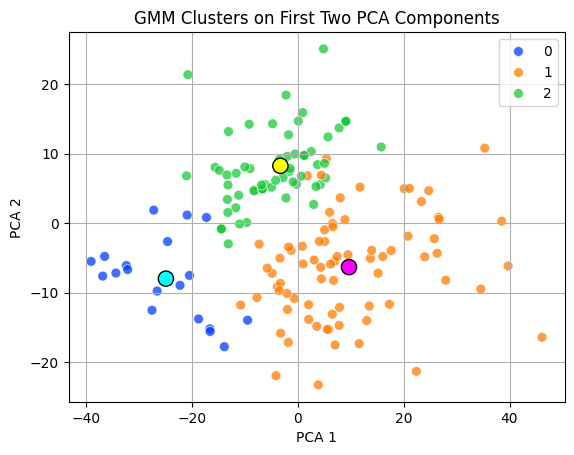

In [ ]:
colors = ["cyan", "magenta","yellow"]
ax1 =sns.scatterplot(data = pd.DataFrame(X_pca[:, :2]), x= 0, y =1, hue = labels, palette="bright", s= 50, alpha=0.75)
ax1.scatter(mu[:,0], mu[:,1], color=colors[:NC], s=120, edgecolor='k', marker="o", label="Cluster Means")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_title("GMM Clusters on First Two PCA Components")
ax1.grid(True)



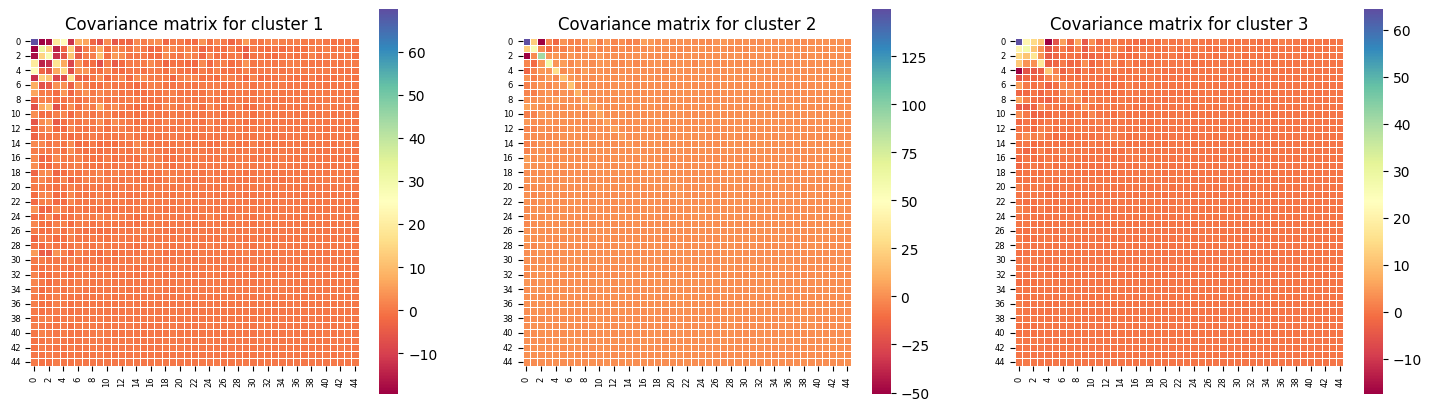

In [19]:
_, ax2 = plt.subplots(1, 3, figsize=(18, 5))

for i in range(sigma.shape[0]):
    sns.heatmap(sigma[i,:,:], ax = ax2[i], cmap="Spectral", square=True, linewidth=0.5)
    ax2[i].set_title(f"Covariance matrix for cluster {i+1}", fontsize= 12)
    ax2[i].tick_params(axis='both', which='major', labelsize=6)


<Figure size 1200x600 with 0 Axes>

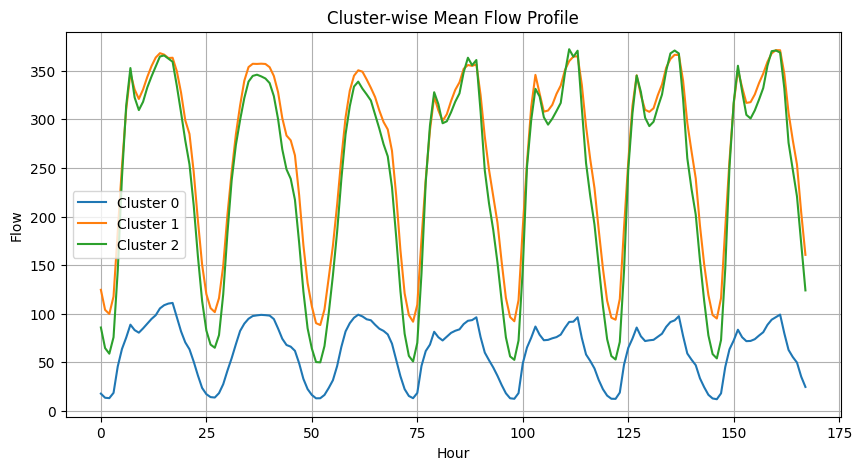

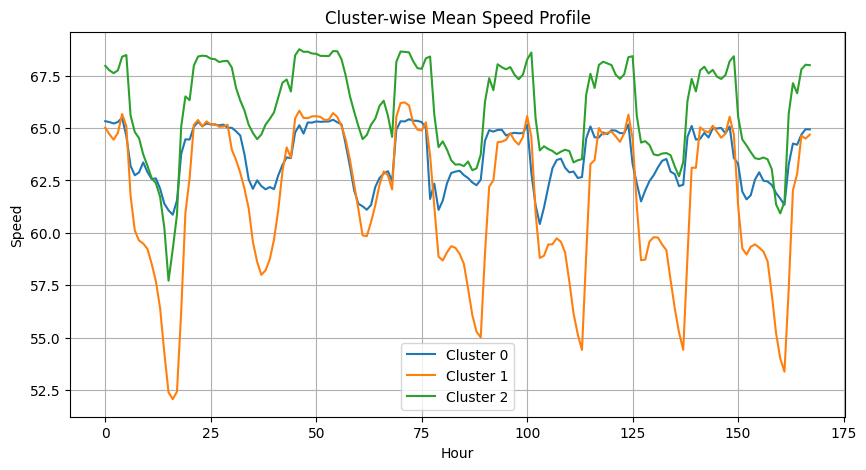

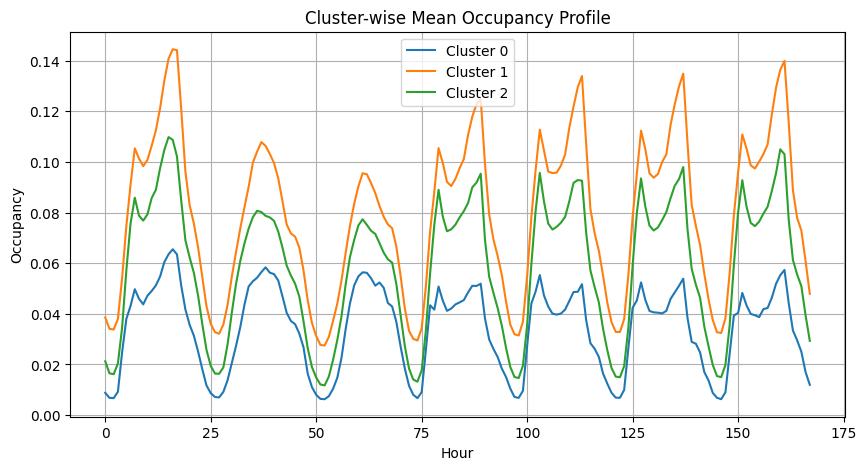

In [64]:
data_weekly_tl['cluster'] = labels
feature_groups = ['flow', 'speed', 'occupancy']
plt.figure(figsize=(12, 6))

for feature in feature_groups:
    plt.figure(figsize=(10, 5))
    cols = [c for c in data_weekly_tl.columns if c.startswith(feature)]
    cluster_means = data_weekly_tl.groupby('cluster')[cols].mean()
    
    # Average hourly values across the week (if applicable)
    cluster_means.columns = np.arange(len(cols))  # rename columns 0..N-1 for hours
    
    # Plot each cluster
    for cluster_id, row in cluster_means.iterrows():
        plt.plot(row.index, row.values, label=f'Cluster {cluster_id}')
    
    plt.title(f'Cluster-wise Mean {feature.capitalize()} Profile')
    plt.xlabel('Hour')
    plt.ylabel(feature.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()
